In [1]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
import numpy as np
import javabridge
import bioformats

In [4]:
# Ignore warnings in notebook
import warnings
warnings.filterwarnings('ignore')

In [5]:
cd ..

/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe


In [6]:
from utils import *

In [7]:
javabridge.start_vm(class_path=bioformats.JARS)

In [8]:
path = '/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/cku-exo1_002/2017-04-12_RAD51-HTP3_cku80-exo1_002_visit_13_D3D_ALX.dv'

In [9]:
image = load_data.load_bioformats(path)

In [10]:
javabridge.kill_vm()

In [11]:
img = image[:,:,:,3]

In [12]:
visualization.browse_images(img)

# Background substraction

In [13]:
ch1 = img_analysis.roll_ball(image, ch=1, size=5)

In [14]:
ch2 = img_analysis.roll_ball(image, ch=2, size=5)

In [15]:
ch3 = img_analysis.roll_ball(image)

# Find Blobs

In [16]:
from skimage.feature import blob_log

In [17]:
blobs = blob_log(ch1,  min_sigma=1, max_sigma=5, threshold=0.08, overlap=0, log_scale=True)

In [18]:
blobs.shape

(569, 4)

In [19]:
# Max intensity projection to visualyse all the blobs
mip = np.amax(ch1, axis=0)

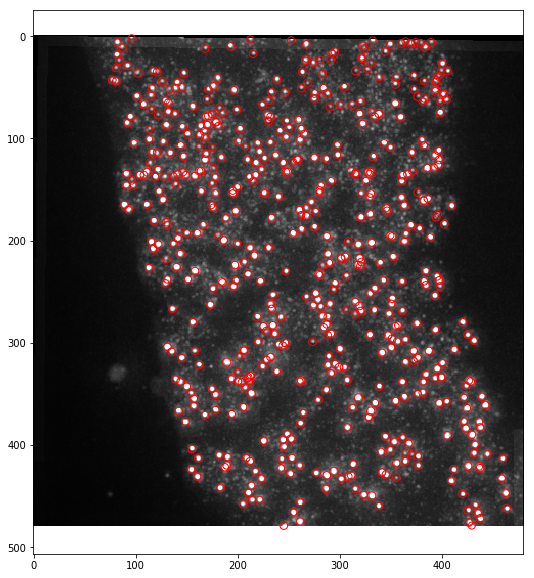

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(mip, vmax=0.3)
for blob in blobs:    
    z,x,y,s = blob
    ax.scatter(y, x, s=s*50, facecolors='none', edgecolors='r')

In [21]:
visualization.browse_blobs(ch1, blobs)

In [22]:
title = []
for x in range(len(ch3)):
    title.append("Z_step_{}".format(x+1))   

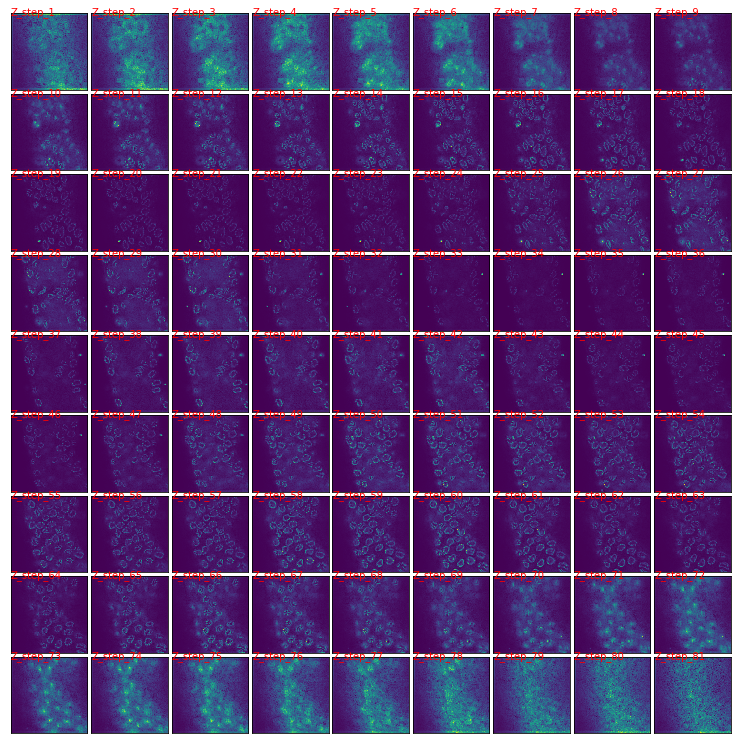

In [23]:
visualization.plot_mosaic(ch3, title)

In [24]:
binary = img_analysis.binarization(ch3)

In [25]:
visualization.browse_images(binary)

In [26]:
from skimage import morphology
from skimage.draw import circle

In [27]:
bbox_ML = np.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/13/bbox_3D.npy")

In [70]:
masked = img_analysis.find_foci(blobs, ch3, binary)

# Find number of foci per cells

### Create an ellipse mask around position of nucleus and give number of foci per nucleus

In [71]:
res = search.binary_select_foci(bbox_ML, ch3, masked)

### Then we find all the foci that were count twice

In [73]:
num, cts, dup_idx, mask = search.find_duplicate(res)

### Remove foci counted twice

In [75]:
new_cts = search.remove_duplicate(cts, dup_idx, res)

### We can plot the result

In [59]:
mip_ch3 = np.amax(ch3,axis=0)

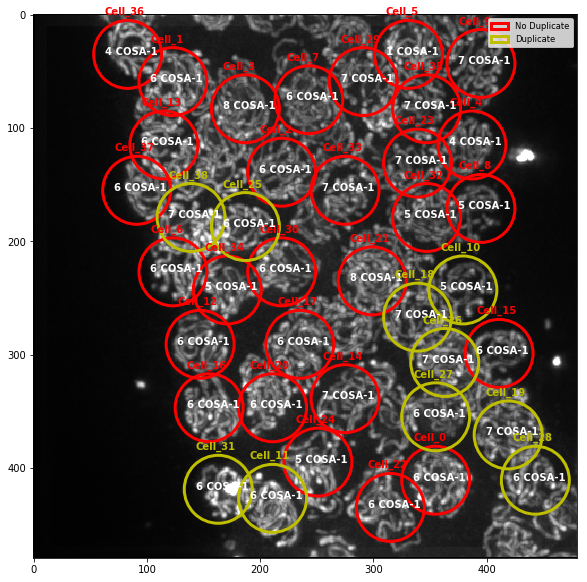

In [96]:
import matplotlib.patches as patches
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(mip_ch3, vmax=0.3)
for coord, val, cell in zip(bbox_ML[~mask],cts[~mask], num[~mask]):
    circles1 = patches.Circle((coord[0]+35,coord[1]+35),30, linewidth=3,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(circles1)
    ax.text(coord[0]+15,coord[1], "Cell_{}".format(str(cell)),color = 'r', weight='bold')
    ax.text(coord[0]+15,coord[1]+35, "{} COSA-1".format(str(val)),color = 'w', weight='bold')
for coord, val, cell in zip(bbox_ML[mask],cts[mask], num[mask]):
    circles2 = patches.Circle((coord[0]+35,coord[1]+35),30, linewidth=3,edgecolor='y',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(circles2)
    ax.text(coord[0]+15,coord[1], "Cell_{}".format(str(cell)),color = 'y', weight='bold')
    ax.text(coord[0]+15,coord[1]+35, "{} COSA-1".format(str(val)),color = 'w', weight='bold')

plt.legend([circles1,circles2], ["No Duplicate","Duplicate"],loc=1,fontsize='small')
    
#plt.savefig('Chloe_result_chrom_3D.png',dpi=200)

In [65]:
mu = np.mean(new_cts)
sigma = np.std(new_cts)

Text(0.5,1,'Histogram of FOCI distribution $\\mu=5.8$, $\\sigma=1.2$')

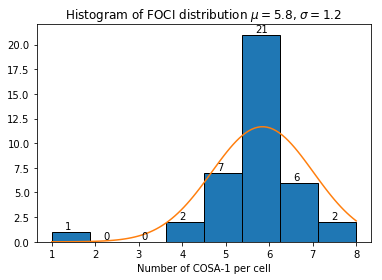

In [67]:
import matplotlib.mlab as mlabs
fig, ax = plt.subplots()
bins = np.max(new_cts)
result = ax.hist(new_cts, bins = bins, edgecolor='black')
for i in range(bins):
    ax.text(result[1][i]+0.3,result[0][i]+0.3,str(int(result[0][i])))
x = np.linspace(min(new_cts), max(new_cts), 100)
dx = result[1][1] - result[1][0]
scale = len(new_cts)*dx
ax.plot(x, mlabs.normpdf(x, mu, sigma)*scale)
ax.set_xlabel('Number of COSA-1 per cell')
ax.set_title(r'Histogram of FOCI distribution $\mu={}$, $\sigma={}$'.format(round(mu,1), round(sigma,1)))
#plt.savefig('foci_dist.png',dpi=150)